# **Homework 2**

## First Iteration ##

In [1]:
import tensorflow as tf

# Check if GPU is available
print('GPU is', 'available' if tf.config.list_physical_devices('GPU') else 'NOT AVAILABLE')

GPU is available


In [2]:
# Cell 1: Import Libraries
import numpy as np
import sys
import gymnasium as gym
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
)
from tensorflow.keras import optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
from gymnasium.wrappers import RecordVideo

In [3]:
# Cell 2: Data Preparation
# Define the paths to your training and validation data
trainingset = 'train/'
validationset = 'test/'

batch_size = 64
target_size = (96, 96)  # Adjust based on your dataset

# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    rotation_range=20,
    shear_range=0.1,
    fill_mode='nearest'
)

# Validation data should not be augmented
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    directory=validationset,
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Gather dataset information
num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = list(train_generator.class_indices.keys())
img_h, img_w, img_channels = input_shape
print(f"Image height = {img_h}, Image Width = {img_w}, Channels = {img_channels}")
print(f"Image input shape: {input_shape}")
print(f"Classes: {classnames}")
print(f"Loaded {num_samples} training samples from {num_classes} classes.")
print(f"Loaded {validation_generator.n} validation samples from {validation_generator.num_classes} classes.")

Found 6369 images belonging to 5 classes.
Found 2749 images belonging to 5 classes.
Image height = 96, Image Width = 96, Channels = 3
Image input shape: (96, 96, 3)
Classes: ['0', '1', '2', '3', '4']
Loaded 6369 training samples from 5 classes.
Loaded 2749 validation samples from 5 classes.


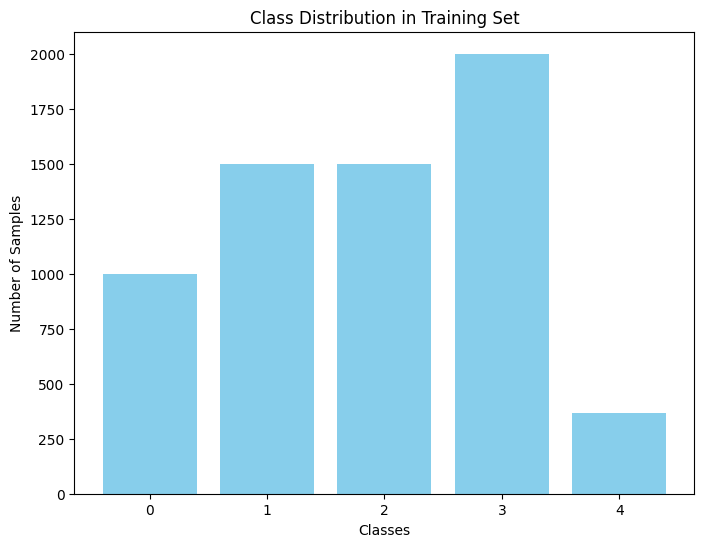

In [4]:
# Cell X: Analyze Class Distribution
import matplotlib.pyplot as plt

# Count of samples per class
class_counts = train_generator.classes
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
plt.bar(class_names, [np.sum(class_counts == i) for i in range(len(class_names))], color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Set')
plt.show()

In [5]:
# Cell Y: Compute Class Weights
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert to a dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.2738, 1: 0.8492, 2: 0.8492, 3: 0.6369, 4: 3.4520325203252034}


In [6]:
# Cell 3: Model Variation 1 - Basic CNN
def BasicCNN(input_shape, num_classes):
    model = Sequential(name="BasicCNN")

    # Convolutional Layers
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile the model
    optimizer = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Instantiate and summarize the model
model_basic = BasicCNN(input_shape, num_classes)
model_basic.summary()

Model: "BasicCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                          

In [7]:
# Cell 5: Deeper CNN with Different Activation
def DeepCNN(input_shape, num_classes):
    model = Sequential(name="DeepCNN")

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimizer = optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Instantiate and summarize the model
model_deep = DeepCNN(input_shape, num_classes)
model_deep.summary()

Model: "DeepCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 48, 48, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        36928     
                                                           

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from tensorflow.keras import optimizers

def RegressionCNN(input_shape, num_outputs=3):
    """
    Defines a CNN model for regression tasks.
    
    Parameters:
    - input_shape (tuple): Shape of the input images (height, width, channels).
    - num_outputs (int): Number of continuous outputs (e.g., steering, gas, brake).
    
    Returns:
    - model (tf.keras.Model): Compiled regression model.
    """
    model = Sequential(name="RegressionCNN")
    
    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    
    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output Layer for Regression
    model.add(Dense(num_outputs, activation='tanh'))  # tanh to bound outputs between -1 and 1
    
    # Compile the model with regression loss
    optimizer = optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    
    return model

# Instantiate the regression model
input_shape = (96, 96, 3)  # Adjust based on your data
model_regression = RegressionCNN(input_shape=input_shape, num_outputs=3)
model_regression.summary()

Model: "RegressionCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 48, 48, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 24, 24, 64)      

In [9]:
# Cell 7: Select Model
# Choose one of the models defined above
model = model_regression  # Replace with model_deep, or model_regression as desired

In [10]:
# Cell 8: Define Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,  # Increased patience for potentially longer training
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,  # Increased patience
    verbose=1,
    min_lr=1e-6
)

# Optionally, add ModelCheckpoint to save the best model
checkpoint = callbacks.ModelCheckpoint(
    'models/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [ ]:
# Cell 9: Train the Model
# Calculate steps per epoch and validation steps
steps_per_epoch = int(np.ceil(train_generator.n / batch_size))
val_steps = int(np.ceil(validation_generator.n / batch_size))

try:
    history = model.fit(
        train_generator,
        epochs=100,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_generator,
        validation_steps=val_steps,
        callbacks=[early_stopping, reduce_lr, checkpoint],
        class_weight=class_weights_dict,
        verbose=1
    )
except KeyboardInterrupt:
    print("Training interrupted.")

# Save the final model
model.save('models/model_final.keras')

In [ ]:
# Cell 10: Evaluate the Model
# Load the best saved model
best_model = load_model('models/model_final.keras')

# Evaluate on validation data
val_steps = int(np.ceil(validation_generator.n / batch_size))
loss, acc = best_model.evaluate(validation_generator, steps=val_steps, verbose=1)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')

In [ ]:
# Cell 11: Classification Report
preds = best_model.predict(validation_generator, steps=val_steps, verbose=0)
Ypred = np.argmax(preds, axis=1)
Ytest = validation_generator.classes  # Ensure shuffle=False in validation_generator

print(classification_report(Ytest, Ypred, target_names=classnames, digits=3))

In [ ]:
# Cell 12: Confusion Matrix
cm = confusion_matrix(Ytest, Ypred)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classnames, yticklabels=classnames, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Cell 13: Text-Based Confusion Matrix
conf = []
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i != j and cm[i][j] > 0:
            conf.append([i, j, cm[i][j]])

conf = np.array(conf)
conf = conf[np.argsort(-conf[:, 2])]  # Sort by descending error count

print(f'{"True":<16} {"Predicted":<16} {"Errors":<10} {"Error %":<10}')
print('-' * 60)
for k in conf:
    true_class = classnames[int(k[0])]
    pred_class = classnames[int(k[1])]
    errors = int(k[2])
    error_pct = (errors / validation_generator.n) * 100
    print(f'{true_class:<16} -> {pred_class:<16} {errors:<10} {error_pct:.2f}%')

In [11]:
from tensorflow.keras.utils import Sequence
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

class RegressionDataGenerator(Sequence):
    def __init__(self, directory, class_to_action, batch_size=32, target_size=(96,96), shuffle=True, augment=False):
        """
        Initializes the data generator.
        
        Parameters:
        - directory (str): Path to the dataset directory containing class subfolders.
        - class_to_action (dict): Mapping from class labels to action vectors.
        - batch_size (int): Number of samples per batch.
        - target_size (tuple): Desired image size (height, width).
        - shuffle (bool): Whether to shuffle data at the end of each epoch.
        - augment (bool): Whether to apply data augmentation.
        """
        self.directory = directory
        self.class_to_action = class_to_action
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.augment = augment
        
        # Initialize data augmentation
        self.datagen = ImageDataGenerator(
            zoom_range=0.1,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            rotation_range=20,
            shear_range=0.1,
            fill_mode='nearest'
        ) if augment else ImageDataGenerator()
        
        # Gather all image paths and corresponding action vectors
        self.image_paths = []
        self.labels = []
        for class_label, action in class_to_action.items():
            class_dir = os.path.join(directory, str(class_label))
            if not os.path.isdir(class_dir):
                continue  # Skip if the class directory does not exist
            for filename in os.listdir(class_dir):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, filename))
                    self.labels.append(action)
        
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        """Denotes the number of batches per epoch."""
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        """Generate one batch of data."""
        # Generate indexes of the batch
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of IDs
        batch_image_paths = [self.image_paths[k] for k in batch_indexes]
        batch_labels = [self.labels[k] for k in batch_indexes]
        
        # Initialize
        batch_images = []
        for img_path in batch_image_paths:
            # Load and preprocess the image
            img = load_img(img_path, target_size=self.target_size)
            img_array = img_to_array(img)
            batch_images.append(img_array)
        batch_images = np.array(batch_images)
        
        # Apply augmentation if enabled
        if self.augment:
            # Apply the same augmentation to all images in the batch
            batch_images_aug = np.zeros_like(batch_images)
            for i in range(batch_images.shape[0]):
                batch_images_aug[i] = self.datagen.random_transform(batch_images[i])
            batch_images = batch_images_aug
        else:
            # Normalize the images
            batch_images = batch_images / 255.0
        
        batch_labels = np.array(batch_labels, dtype=np.float32)
        return batch_images, batch_labels
    
    def on_epoch_end(self):
        """Updates indexes after each epoch."""
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [12]:
# Define mapping from class labels to action vectors
class_to_action = {
    0: [0.0, 0.0, 0.0],    # No Action
    1: [-1.0, 0.0, 0.0],   # Steer Left
    2: [1.0, 0.0, 0.0],    # Steer Right
    3: [0.0, 1.0, 0.0],    # Accelerate (Gas)
    4: [0.0, 0.0, 1.0],    # Brake
}

# Paths to your data
train_images_dir = 'train/'  # Directory containing subfolders 0,1,2,3,4
val_images_dir = 'test/'     # Directory containing subfolders 0,1,2,3,4

batch_size = 64
target_size = (96, 96)  # Adjust based on your requirements

# Create training and validation generators
train_regression_generator = RegressionDataGenerator(
    directory=train_images_dir,
    class_to_action=class_to_action,
    batch_size=batch_size,
    target_size=target_size,
    shuffle=True,
    augment=True  # Enable augmentation for training
)

val_regression_generator = RegressionDataGenerator(
    directory=val_images_dir,
    class_to_action=class_to_action,
    batch_size=batch_size,
    target_size=target_size,
    shuffle=False,
    augment=False  # No augmentation for validation
)

In [13]:
# Calculate steps per epoch and validation steps
steps_per_epoch = int(np.ceil(len(train_regression_generator.image_paths) / batch_size))
val_steps = int(np.ceil(len(val_regression_generator.image_paths) / batch_size))

try:
    history = model_regression.fit(
        train_regression_generator,
        epochs=100,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_regression_generator,
        validation_steps=val_steps,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
except KeyboardInterrupt:
    print("Training interrupted.")

# Save the final model
model_regression.save('models/model_final_regression.keras')

Epoch 1/100
100/100 [==============================] - 17s 129ms/step - loss: 1.0427 - mae: 0.8809 - val_loss: 0.6483 - val_mae: 0.7166 - lr: 1.0000e-04
Epoch 2/100
100/100 [==============================] - 12s 124ms/step - loss: 1.0330 - mae: 0.8760 - val_loss: 0.6523 - val_mae: 0.7186 - lr: 1.0000e-04
Epoch 3/100
100/100 [==============================] - 13s 125ms/step - loss: 1.0330 - mae: 0.8760 - val_loss: 0.6521 - val_mae: 0.7187 - lr: 1.0000e-04
Epoch 4/100
100/100 [==============================] - 12s 124ms/step - loss: 1.0332 - mae: 0.8761 - val_loss: 0.6521 - val_mae: 0.7187 - lr: 1.0000e-04
Epoch 5/100
100/100 [==============================] - 13s 128ms/step - loss: 1.0332 - mae: 0.8761 - val_loss: 0.6532 - val_mae: 0.7188 - lr: 1.0000e-04
Epoch 6/100
100/100 [==============================] - ETA: 0s - loss: 1.0330 - mae: 0.8760
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
100/100 [==============================] - 13s 127ms/step - loss: 

In [14]:
# Load the best saved model
best_model_regression = load_model('models/model_final_regression.keras')

# Evaluate on validation data
loss, mae = best_model_regression.evaluate(val_regression_generator, steps=val_steps, verbose=1)
print(f'Test Loss (MSE): {loss:.4f}')
print(f'Test MAE: {mae:.4f}')

43/43 [==============================] - 1s 28ms/step - loss: 0.6483 - mae: 0.7166
Test Loss (MSE): 0.6483
Test MAE: 0.7166


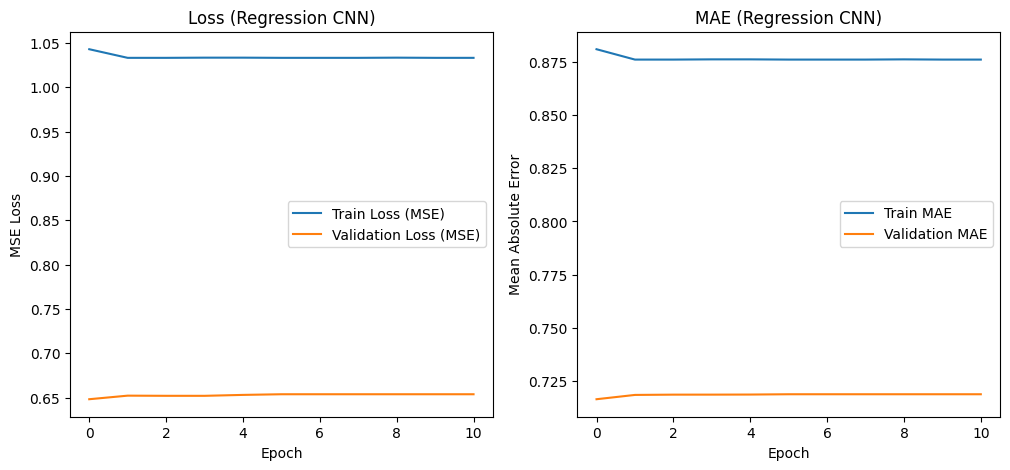

In [15]:
import matplotlib.pyplot as plt

def plot_training_history(history, title_suffix=''):
    """
    Plots training and validation loss and MAE.
    
    Parameters:
    - history (tf.keras.callbacks.History): History object from model training.
    - title_suffix (str): Suffix to add to plot titles.
    """
    # Plot Loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
    plt.title(f'Loss {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    
    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(f'MAE {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    
    plt.show()

# Plot the training history
plot_training_history(history, title_suffix='(Regression CNN)')

In [17]:
# Cell 9: Model Deployment with Gymnasium (Final Revised for Continuous Actions)
import numpy as np
from gymnasium.wrappers import RecordVideo

def play(env, model, predefined_actions):
    seed = 2000
    obs, _ = env.reset(seed=seed)

    # Drop initial frames with no action
    no_action = predefined_actions[0]  # [0.0, 0.0, 0.0]
    for _ in range(50):
        obs, _, _, _, _ = env.step(no_action)

    done = False
    while not done:
        # Preprocess the observation
        img = preprocess_observation(obs, target_size)
        p = model.predict(np.expand_dims(img, axis=0))  # Shape: (1, 5)
        predicted_class = np.argmax(p)  # Integer 0-4

        # Map the predicted class to a predefined action
        action = predefined_actions.get(predicted_class, predefined_actions[0])  # Array

        # Ensure the action is a float32 NumPy array
        action = action.astype(np.float32)

        # Step the environment with the action
        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    env.close()

def preprocess_observation(obs, target_size):
    from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

    # Convert observation to PIL Image
    img = array_to_img(obs)
    # Resize image
    img = img.resize(target_size)
    # Convert to array and normalize
    img = img_to_array(img) / 255.0
    return img

# Define predefined actions (Continuous)
predefined_actions = {
    0: np.array([0.0, 0.0, 0.0], dtype=np.float32),  # No Action
    1: np.array([-1.0, 0.0, 0.0], dtype=np.float32), # Steer Left
    2: np.array([1.0, 0.0, 0.0], dtype=np.float32),  # Steer Right
    3: np.array([0.0, 1.0, 0.0], dtype=np.float32),  # Accelerate (Gas)
    4: np.array([0.0, 0.0, 1.0], dtype=np.float32),  # Brake
    # Add more actions as needed
}

# Initialize the environment without 'continuous' parameter
env_arguments = {
    'domain_randomize': False,
    'render_mode': 'rgb_array'
}

env_name = 'CarRacing-v3'
env = gym.make(env_name, **env_arguments)

# Wrap the environment to record videos
video_dir = 'video_recordings'  # Specify the directory to save video recordings
env = RecordVideo(env, video_dir)

print("Environment:", env_name)
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)

# Play the game using the trained model
#play(env, best_model, predefined_actions)
play(env, best_model_regression, predefined_actions)

c:\Users\andri\miniconda3\envs\tf\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\andri\Documents\GitHub\Homework-2\video_recordings folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Environment: CarRacing-v3
Action space: Box([-1.  0.  0.], 1.0, (3,), float32)
Observation space: Box(0, 255, (96, 96, 3), uint8)
1/1 [==============================] - 0s 16ms/step
